# Stock Predictor with RNN using Keras and Tensorflow

In this project, I perform a time series prediction using a Recurrent Neural Network regressor. For this example, I will predict Apple's stock price 7 days in advance.

The particular network architecture I will employ for my RNN is a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [2]:
## Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install keras

    100% |████████████████████████████████| 317kB 85kB/s ta 0:00:011


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./data/sandp500/"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


all_stocks_5yr.csv
getSandP.py
individual_stocks_5yr.zip
merge.sh
test_stock_downloader



In [2]:
data = pd.read_csv('./data/sandp500/all_stocks_5yr.csv')
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'Name'], dtype='object')

In [3]:
#data.Name.value_counts().plot(kind='bar')
#plt.title("Count of each stock in the dataset")

## check how many stocks have more than 1000 data samples:
stock_count = data["Name"].value_counts().to_frame()
print(sum(data['Name'].value_counts() > 1000), "stocks have more than 1000 data entries")

df = data.groupby('Name').filter(lambda l: len(l) > 1000)
#print(df['Name'].nunique())
#df.head(2)
#print(stock_count)

483 stocks have more than 1000 data entries


In [4]:
## interesting company and their stock code:

## Google: GOOGL
## Amazon: AMZN
## Apple: AAPL
## Facebook: FB
## Microsoft: MSFT
## Netflix: NFLX

## Expedia: EXPE, Morgan-Stanley: MS, Nasdaq: NDAQ, Bestbuy: BBY, Coca-cola: KO, Starbucks: SBUX

stock_list = ['GOOGL','AMZN','AAPL','FB','MSFT','NFLX']

stock_code = {'GOOGL':'Google','AMZN':'Amazon','AAPL':'Apple','FB':'Facebook','MSFT':'Microsoft','NFLX':'Netflix'}

stock_data = {'GOOGL':[],'AMZN':[],'AAPL':[],'FB':[],'MSFT':[],'NFLX':[]}

for name in stock_data.keys():
    close_price = df[df['Name'] == name].close.values
    close_price = close_price.reshape(-1, 1)
    stock_data[name] = close_price
for name in stock_data.keys():
    print("How many data sample for " + name + " ? : " + str(len(stock_data[name])))

How many data sample for GOOGL ? : 1259
How many data sample for AMZN ? : 1259
How many data sample for AAPL ? : 1259
How many data sample for FB ? : 1259
How many data sample for MSFT ? : 1259
How many data sample for NFLX ? : 1259


In [5]:
## create a map for data scalers:
scalers = {}
for code, name in stock_code.items():
    scalers[code] = MinMaxScaler()

## scaled the stock data:
scaled_stock_data = {}
for code, data in stock_data.items():
    scaled_stock_data[code] =  scalers[code].fit_transform(data)

## formated print-out:
for code, data in scaled_stock_data.items():
    print(code + " data: [", data[0][0], data[1][0], data[2][0], " ... ]")

GOOGL data: [ 0.012108253960359139 0.010272313546044687 0.009201835318693896  ... ]
AMZN data: [ 0.011408045499143538 0.007466781966640579 0.008705702359769169  ... ]
AAPL data: [ 0.09771029585300417 0.10343799834939804 0.08951883897397017  ... ]
FB data: [ 0.033174492188188576 0.03149990305010253 0.02627048433818474  ... ]
MSFT data: [ 0.0026611472501478217 0.007244234180957987 0.007539917208752189  ... ]
NFLX data: [ 0.009791588610145507 0.008107672648267839 0.008140585551159082  ... ]


## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [6]:
#Create a function to process the data into look back slices
def window_data(data, size):
    X,Y = [],[]
    for i in range(len(data) - size):
        X.append(data[i:(i+size),0])
        Y.append(data[(i+size),0])
    return np.array(X),np.array(Y)

## test the function:
X,Y = window_data(scaled_stock_data['GOOGL'],7)
print("Shape of X: ", X.shape)
print("Shape of Y: ", Y.shape)

Shape of X:  (1252, 7)
Shape of Y:  (1252,)


## Step 3: Split training and testing sets

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 4/5 of it), and validate on a later chunk (the last 1/5) as this simulates how we would predict *future* values of a time series.

In [7]:
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
Y_train,Y_test = Y[:int(Y.shape[0]*0.80)],Y[int(Y.shape[0]*0.80):]
print("Training set shape of X: ", X_train.shape)
print("Test set shape of X: ", X_test.shape)
print("Training set shape of Y: ", Y_train.shape)
print("Test set shape of Y: ", Y_test.shape)

Training set shape of X:  (1001, 7)
Test set shape of X:  (251, 7)
Training set shape of Y:  (1001,)
Test set shape of Y:  (251,)


## Step 4:  Build and run RNN regression model

After created input/output pairs and cut the data into training/testing sets, we can now begin setting up our RNN.

We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [8]:
## Split and reshape the data for model training:

def split_reshape(X, Y, percent):
    ## split the data
    X_train, X_test = X[:int(X.shape[0]*percent)], X[int(X.shape[0]*percent):]
    Y_train, Y_test = Y[:int(Y.shape[0]*percent)], Y[int(Y.shape[0]*percent):]
    
    ## Reshape data for (Sample, Timestep, Features) 
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, Y_train, X_test, Y_test

In [9]:
## define function for model initialization:

def model_initialize(T):
    model = Sequential()
    model.add(LSTM(64,input_shape = (T,1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [10]:
## define callback function to control prompt output:

from keras.callbacks import Callback

class NPochLogger(Callback):
    
    def __init__(self, skip = 200):
        ## display: Number of batches to wait before outputting loss
        self.seen = 1
        self.skip = skip
        
    def on_epoch_end(self, batch, logs={}):
        
        if self.seen == 1 or self.seen % self.skip == 0:
            print(f" epoch: {self.seen} -- Loss: {logs['loss']}  --  val_loss: {logs['val_loss']}")
            
        self.seen += 1

In [11]:
## ---------------------------------------------------------------------------------
## define function for model training:

## code: code for the stock, e.g.: GOOGL for Google
## Ts: a list ot window sizes
## n_epoch, n_skip: number of epochs, print loss every n_skip epochs

def train_model(code, Ts, m_epoch, n_skip):
    
    ## create lists to store models, histories and predictions:
    if len(Ts) != 4:
        print("Length of window size list must be 4!")
        return None, None, None
    
    models, histories, preds = [], [], []

    ## create figure and axes object:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axis = [ axes[0][0], axes[0][1], axes[1][0], axes[1][1] ]
    
    print("# # # # # # # # # # Train the model for stock: " + stock_code[code] + " # # # # # # # # # #")

    for i in range(len(Ts)):
    
        ## time slot for training:
        T = Ts[i]
        print(f"----------- With time window size being {T} ------------")
    
        ## window the data using T
        X, Y = window_data(scaled_stock_data[code], T)
    
        ## split and reshape the data:
        X_train, Y_train, X_test, Y_test = split_reshape(X, Y, 0.8)
    
        ## initialize model:
        model = model_initialize(T)
    
        ## instantiate NPochLogger() object, pass in n_skip:
        logger = NPochLogger(n_skip)
    
        ## Fit model with history check and callbacks:
        history = model.fit(X_train, Y_train, epochs = n_epoch,validation_data = (X_test,Y_test),
                            shuffle = False, verbose = 0, callbacks = [logger])
    
        ## record models, histories and predictions:
        models.append(model)
        histories.append(history)
        preds.append(model.predict(X_test))
    
        ## start to plot:
        axis[i].plot(history.history['loss'], label = "loss on training set")
        axis[i].plot(history.history['val_loss'], label = "loss on validation set")
        axis[i].legend(loc='best')
        axis[i].set_xlabel("Epoch")
        axis[i].set_ylabel("Loss")
        axis[i].set_title( stock_code[code] + ": Model loss for window size " + str(T))

    plt.tight_layout()
    
    return models, histories, preds


## Step 5: Try different window size on the models
### here we use defined function (see above cells) to encapsulate the model training
### Note the following variables:
### - models, histories, preds: list of model training result for each window size
### - stock_model_records: dictionary, key is stock code, value is a list  [models, histories, preds]


### 5.1: Train the model for Google (GOOGL)

# # # # # # # # # # Train the model for stock: Google # # # # # # # # # #
----------- With time window size being 3 ------------
 epoch: 1 -- Loss: 0.0054681774277974705  --  val_loss: 0.002360888235714464
 epoch: 500 -- Loss: 0.00014486718114439502  --  val_loss: 0.0001889524804908664
----------- With time window size being 5 ------------
 epoch: 1 -- Loss: 0.0036527812435660336  --  val_loss: 0.005719758536800208
 epoch: 500 -- Loss: 0.00013990150102711788  --  val_loss: 0.00022889472441228322
----------- With time window size being 7 ------------
 epoch: 1 -- Loss: 0.003602234689534161  --  val_loss: 0.004877932291789597
 epoch: 500 -- Loss: 0.0002940913288587505  --  val_loss: 0.001576489614938716
----------- With time window size being 10 ------------
 epoch: 1 -- Loss: 0.004268389565192416  --  val_loss: 0.003525605175644159
 epoch: 500 -- Loss: 0.00013761964783862732  --  val_loss: 0.00025098439399152993


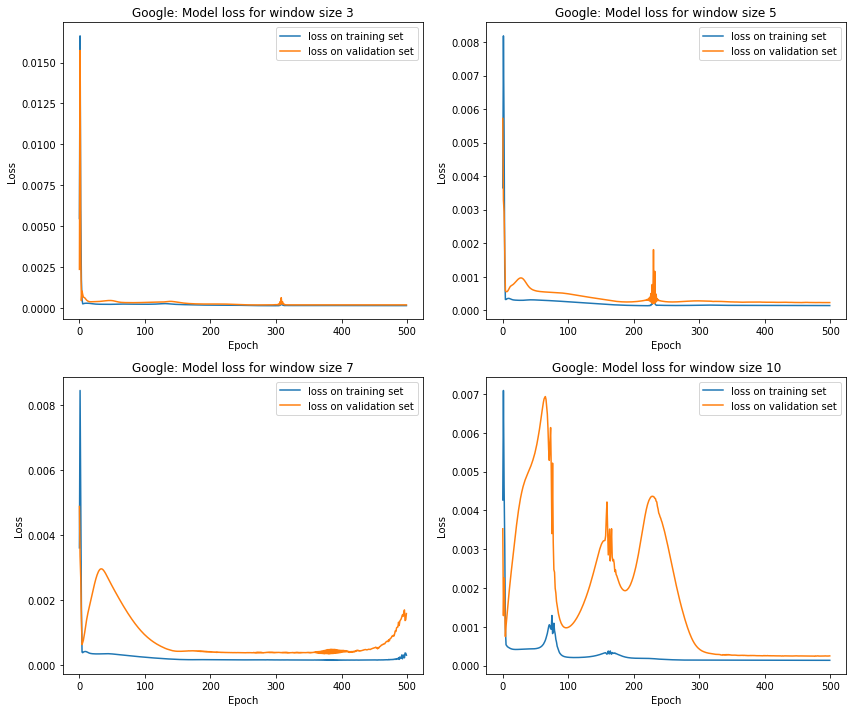

In [13]:
## ignore warnings:
import warnings
warnings.filterwarnings('ignore')

## Ts: a list ot window sizes
## n_epoch, n_skip: number of epochs, print loss every n_skip epochs
Ts = [3, 5, 7, 10]
n_epoch, n_skip = 500, 500

## create a dictionary to store model training results: models, histories, preds for all window sizes
stock_model_records = {}

## pick up a stock and train it, code is the code for the stock, e.g.: GOOGL for Google
code = "GOOGL"
models, histories, preds = train_model(code, Ts, n_epoch, n_skip)

## store the model info:
stock_model_records[code] = [models, histories, preds]

### 5.2: Train the model for Amazon (AMZN)

# # # # # # # # # # Train the model for stock: Amazon # # # # # # # # # #
----------- With time window size being 3 ------------
 epoch: 1 -- Loss: 0.012309889557360452  --  val_loss: 0.07336529143272884
 epoch: 500 -- Loss: 7.081908488435581e-05  --  val_loss: 0.0004562783625072962
----------- With time window size being 5 ------------
 epoch: 1 -- Loss: 0.004296244806593798  --  val_loss: 0.002597000817230261
 epoch: 500 -- Loss: 6.557547616501221e-05  --  val_loss: 0.0005152695274269914
----------- With time window size being 7 ------------
 epoch: 1 -- Loss: 0.004370147698688191  --  val_loss: 0.00294304603573484
 epoch: 500 -- Loss: 6.300916983047034e-05  --  val_loss: 0.0006717707594463313
----------- With time window size being 10 ------------
 epoch: 1 -- Loss: 0.005176286150172756  --  val_loss: 0.003189452301710844
 epoch: 500 -- Loss: 6.662764008160684e-05  --  val_loss: 0.0003800875558517873


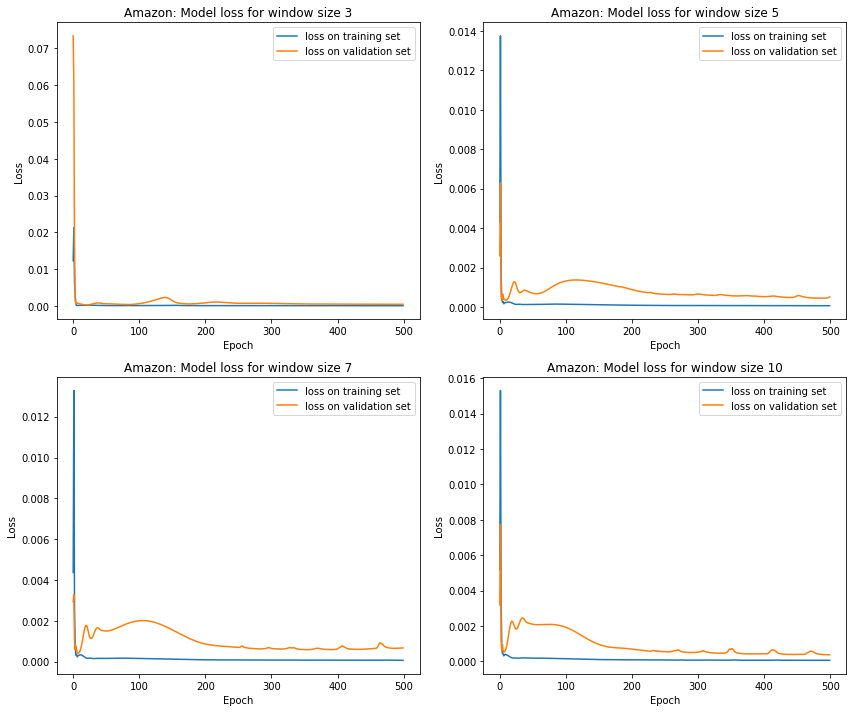

In [16]:
## pick up a stock and train it
## stock_list = ['GOOGL','AMZN','AAPL','FB','MSFT','NFLX']
code = "AMZN"

## store the model info:
stock_model_records[code] = train_model(code, Ts, n_epoch, n_skip)

### 5.3: Train the model for Apple (AAPL)

# # # # # # # # # # Train the model for stock: Apple # # # # # # # # # #
----------- With time window size being 3 ------------
 epoch: 1 -- Loss: 0.018079636322354816  --  val_loss: 0.008321057805525405
 epoch: 500 -- Loss: 0.00016528079903079754  --  val_loss: 0.00022687968319385417
----------- With time window size being 5 ------------
 epoch: 1 -- Loss: 0.008996257136561022  --  val_loss: 0.023497768889266656
 epoch: 500 -- Loss: 0.00019523949844712542  --  val_loss: 0.0002818885688350881
----------- With time window size being 7 ------------
 epoch: 1 -- Loss: 0.01110533114381276  --  val_loss: 0.04658608286979189
 epoch: 500 -- Loss: 0.00016960073149643027  --  val_loss: 0.00023600641780429003
----------- With time window size being 10 ------------
 epoch: 1 -- Loss: 0.004024009359208074  --  val_loss: 0.054310919225215915
 epoch: 500 -- Loss: 0.00015292854155054888  --  val_loss: 0.00023335691494867205


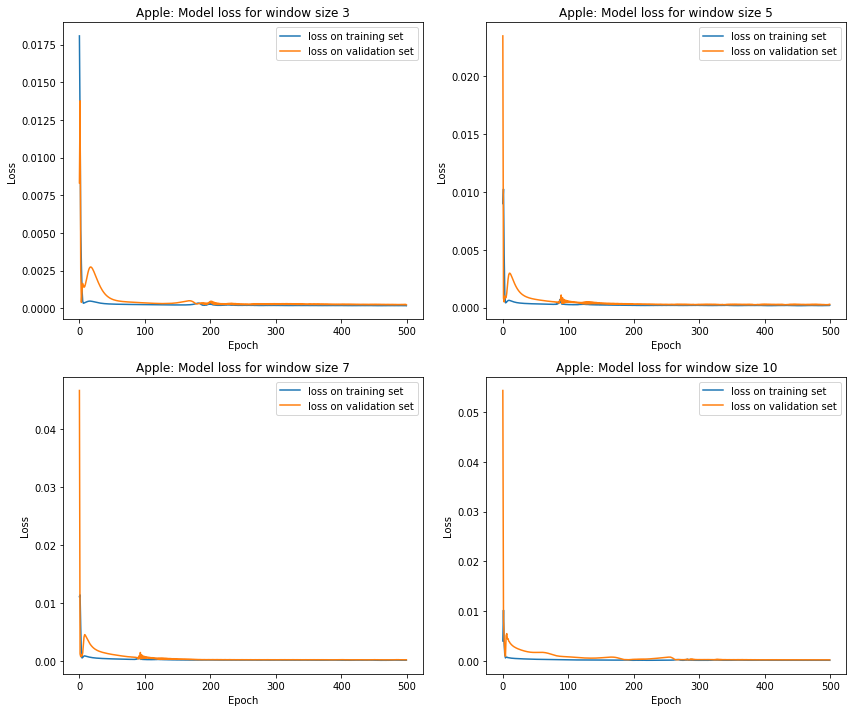

In [35]:
code = "AAPL"

## store the model info:
stock_model_records[code] = train_model(code, Ts, n_epoch, n_skip)

### 5.4: Train the model for Facebook (FB)

# # # # # # # # # # Train the model for stock: Facebook # # # # # # # # # #
----------- With time window size being 3 ------------
 epoch: 1 -- Loss: 0.031578799050725234  --  val_loss: 0.031752183974262264
 epoch: 500 -- Loss: 9.195136852619012e-05  --  val_loss: 0.0002360384493681883
----------- With time window size being 5 ------------
 epoch: 1 -- Loss: 0.010605595796879712  --  val_loss: 0.0018855696748125838
 epoch: 500 -- Loss: 8.560901004787403e-05  --  val_loss: 0.00032352424083848994
----------- With time window size being 7 ------------
 epoch: 1 -- Loss: 0.008093299030639848  --  val_loss: 0.014154969146883346
 epoch: 500 -- Loss: 8.315333320138666e-05  --  val_loss: 0.00017215770231448558
----------- With time window size being 10 ------------
 epoch: 1 -- Loss: 0.0030517296481493475  --  val_loss: 0.001020595757290721
 epoch: 500 -- Loss: 8.36644959546303e-05  --  val_loss: 0.00015295684430748224


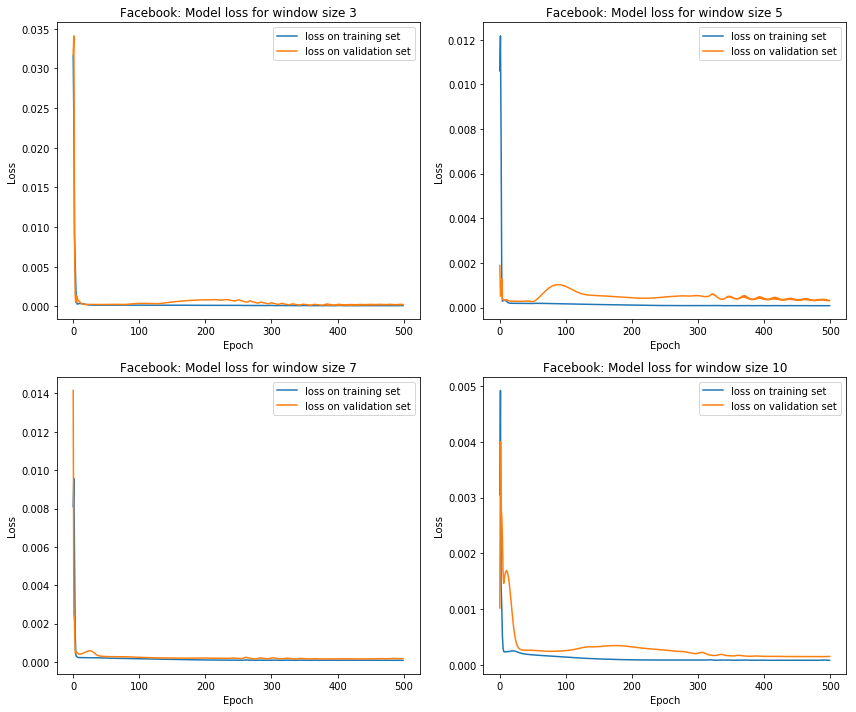

In [36]:
code = "FB"

## store the model info:
stock_model_records[code] = train_model(code, Ts, n_epoch, n_skip)

### 5.5: Train the model for Microsoft (MSFT)

# # # # # # # # # # Train the model for stock: Microsoft # # # # # # # # # #
----------- With time window size being 3 ------------
 epoch: 1 -- Loss: 0.011694576863971245  --  val_loss: 0.01866495913811146
 epoch: 500 -- Loss: 0.00011252075138866375  --  val_loss: 0.00031793051877886884
----------- With time window size being 5 ------------
 epoch: 1 -- Loss: 0.001394123787793692  --  val_loss: 0.0016205367127589258
 epoch: 500 -- Loss: 0.00010861280721530795  --  val_loss: 0.0013030895191537906
----------- With time window size being 7 ------------
 epoch: 1 -- Loss: 0.0032132159600817747  --  val_loss: 0.00727377951226802
 epoch: 500 -- Loss: 0.0001140658844539851  --  val_loss: 0.0020245129954017905
----------- With time window size being 10 ------------
 epoch: 1 -- Loss: 0.001979998384907215  --  val_loss: 0.0026129089072346686
 epoch: 500 -- Loss: 0.00010953310449441962  --  val_loss: 0.0002407515337690711


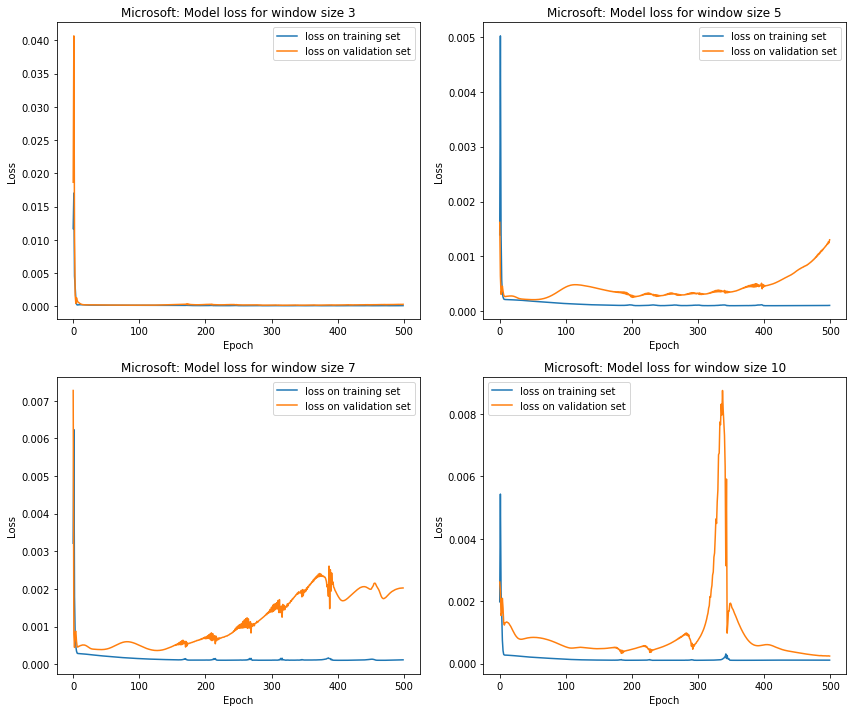

In [41]:
code = "MSFT"

## store the model info:
stock_model_records[code] = train_model(code, Ts, n_epoch, n_skip)

### 5.5: Train the model for Netflix (NFLX)

# # # # # # # # # # Train the model for stock: Netflix # # # # # # # # # #
----------- With time window size being 3 ------------
 epoch: 1 -- Loss: 0.0038380410677133743  --  val_loss: 0.017517792386195018
 epoch: 500 -- Loss: 9.352653109655433e-05  --  val_loss: 0.0002336125785765785
----------- With time window size being 5 ------------
 epoch: 1 -- Loss: 0.002464404841513556  --  val_loss: 0.018200170679158897
 epoch: 500 -- Loss: 8.609253310021347e-05  --  val_loss: 0.0002356385909562626
----------- With time window size being 7 ------------
 epoch: 1 -- Loss: 0.002128521755842918  --  val_loss: 0.007853375651328213
 epoch: 500 -- Loss: 8.577893609830577e-05  --  val_loss: 0.0011750207462559539
----------- With time window size being 10 ------------
 epoch: 1 -- Loss: 0.0027196475411755956  --  val_loss: 0.011514918535947799
 epoch: 500 -- Loss: 9.27123022050294e-05  --  val_loss: 0.0003002030486240983


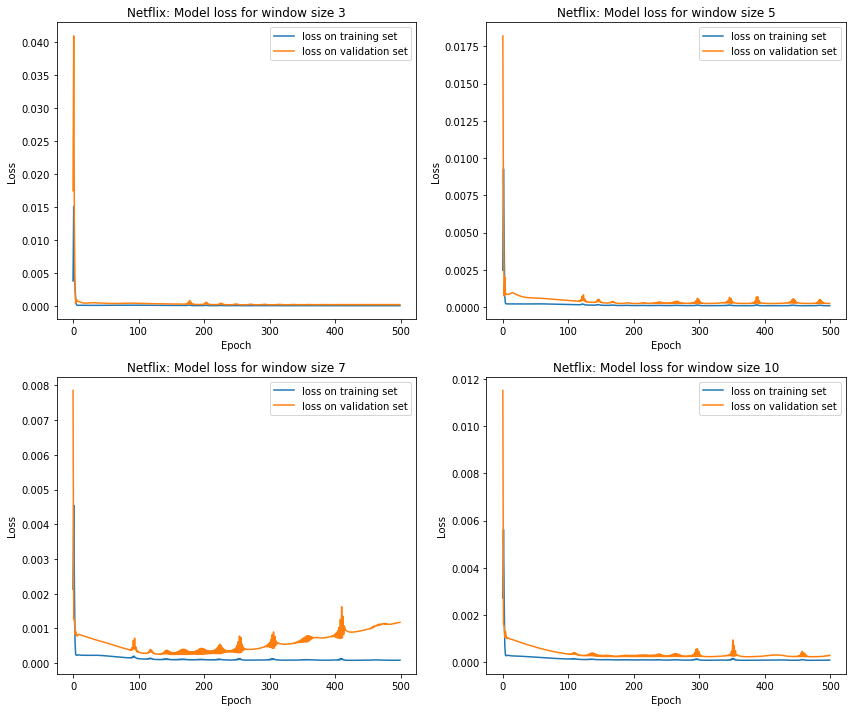

In [43]:
code = "NFLX"

## store the model info:
stock_model_records[code] = train_model(code, Ts, n_epoch, n_skip)

## Step 6: Checking model performance for all the chosen stocks

#### With our model fit we can now make predictions on both our training and testing sets.

In [45]:
## define function for plot

def plot_stock_price(two_codes, Ts):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    for i in range(2):
        ## stock code:
        code = two_codes[i]
        
        ## window the data using T
        X, Y = window_data(scaled_stock_data[code], 5)
        ## split and reshape the data:
        _, _, _, Y_test = split_reshape(X, Y, 0.8)
        
        ## recover prediction:
        _, _, preds = stock_model_records[code]
        
        ## plot real stock price first:
        axes[i].plot(scalers[code].inverse_transform(Y_test.reshape(-1,1)), label = "Real price")

        ## plot all predictions for different window size:
        for j in range(len(preds)):
            T = Ts[j]
            pred_test = preds[j]
            axes[i].plot(scalers[code].inverse_transform(pred_test), label = "Predicted price with window size " + str(T))
        
        axes[i].legend(loc='best')
        axes[i].set_xlabel("Day")
        axes[i].set_ylabel("Stock Price")
        axes[i].set_title("Stock price for " + stock_code[code] + " (" + code + ")")
        
    return

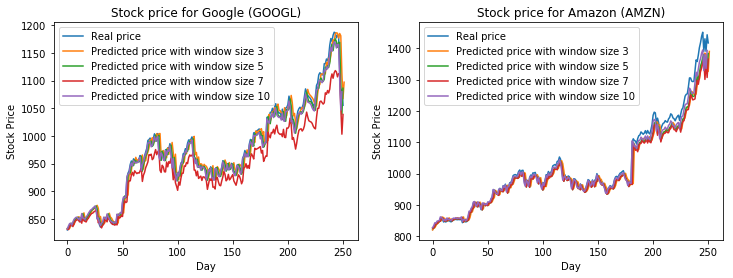

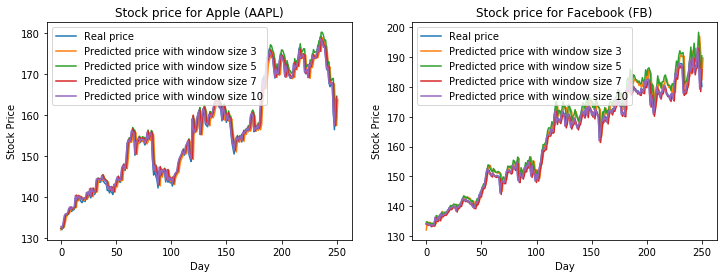

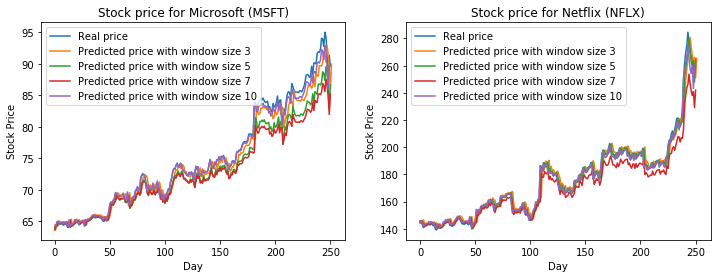

In [46]:
#stock_list = ['GOOGL','AMZN']#,'AAPL','FB','MSFT','NFLX']

plot_stock_price(['GOOGL','AMZN'], Ts)

plot_stock_price(['AAPL','FB'], Ts)

plot_stock_price(['MSFT','NFLX'], Ts)

In [60]:
act = []
pred = []

i=249

for code, name in stock_code.items():
    
    ## window the data using T
    X, Y = window_data(scaled_stock_data[code], 5)
    ## split and reshape the data:
    X_train, Y_train, X_test, Y_test = split_reshape(X, Y, 0.8)
    
    ## models[code] = [model for T = 3, model for T = 5, model for T = 7, model for T = 10]
    x = stock_model_records[code][0][1].predict(X_test[i].reshape(1,5,1))
    y = scalers[code].inverse_transform(Y_test[i].reshape(-1,1))
    pred = scalers[code].inverse_transform(x)
    print(f"For {name} stock at day {i}: actual price = {y[0][0]}, predicted price = {pred[0][0]}, error = {round(100.0*abs(y[0][0]-pred[0][0])/y[0][0], 1)}%")


For Google stock at day 249: actual price = 1084.43, predicted price = 1039.3277587890625, error = 4.2%
For Amazon stock at day 249: actual price = 1442.84, predicted price = 1321.1124267578125, error = 8.4%
For Apple stock at day 249: actual price = 163.03, predicted price = 157.96310424804688, error = 3.1%
For Facebook stock at day 249: actual price = 185.31, predicted price = 182.02474975585938, error = 1.8%
For Microsoft stock at day 249: actual price = 91.33, predicted price = 82.9014663696289, error = 9.2%
For Netflix stock at day 249: actual price = 265.72, predicted price = 247.8564453125, error = 6.7%


In [52]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

In [53]:
#result_df.plot(kind='line')

In [82]:
# plot original data
code = 'GOOGL'
T = 5

## stock_code = {"code":"stock name"} e.g. "GOOGL":"Google"
def plot_full_data(stock_code, T):
    
    fig, axes = plt.subplots(3, 2, figsize=(10, 12))
    axis = [ axes[0][0], axes[0][1], axes[1][0], axes[1][1], axes[2][0], axes[2][1] ]
    
    ind = -1
    
    for code, name in stock_code.items():
        ind += 1
        X, Y = window_data(scaled_stock_data[code], 5)
        X_train, Y_train, X_test, Y_test = split_reshape(X, Y, 0.8)
        
        ## stock_model_records[code][0][1]: 0 -> models, 1 -> models[T=5]
        pred_train = stock_model_records[code][0][1].predict(X_train)
        pred_test = stock_model_records[code][0][1].predict(X_test)
        
        ## plot original of 'code':
        axis[ind].plot(scalers[code].inverse_transform(Y.reshape(-1,1)), color='k', label="Original data")
        
        ## plot predicted data on train and test sets:
        split_pt = int(X.shape[0]*0.80) + T # T is window_size
        axis[ind].plot(np.arange(T, split_pt, 1), scalers[code].inverse_transform(pred_train), color='b', label="Train fit")
        axis[ind].plot(np.arange(split_pt, split_pt+len(X_test), 1), scalers[code].inverse_transform(pred_test), color='r', label="Test fit")
        
        # pretty up graph
        axis[ind].set_xlabel('day')
        axis[ind].set_ylabel(f'{name} stock price')
        #plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
        axis[ind].legend(loc='upper left')
    
    plt.tight_layout()
    return

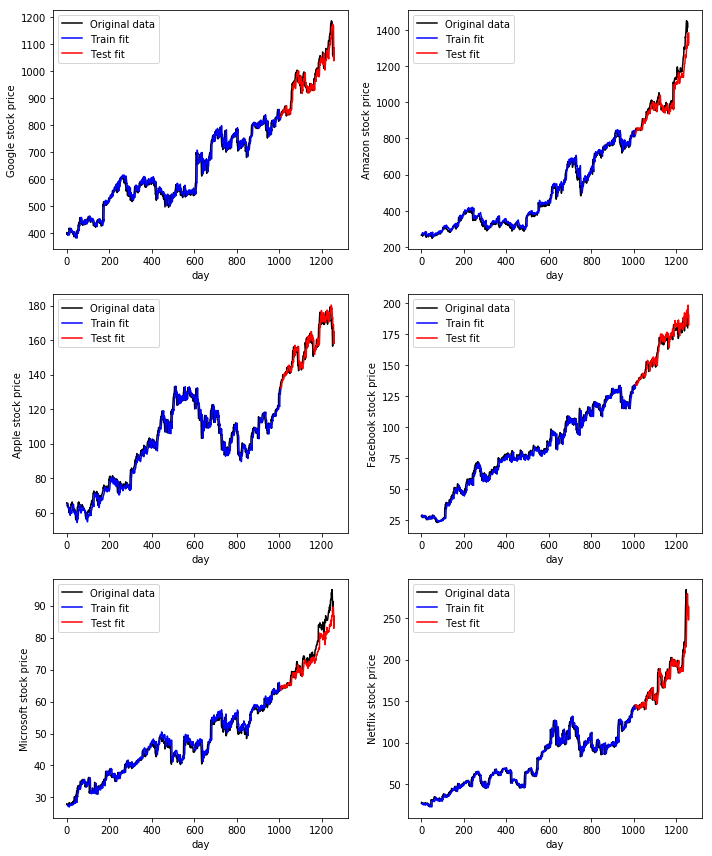

In [83]:
plot_full_data(stock_code, 5)